# Create a shape vs area plot

Plot showing the conceptual backbone of the method with polygons identified as artifacts highlighted.

In [22]:
import os
import json
os.environ['USE_PYGEOS'] = '0'

import geopandas
import geodatasets
import pandas
import numpy
import matplotlib.pyplot as plt
import seaborn as sns
from palettable.cartocolors.qualitative import Bold_6
from matplotlib.lines import Line2D
from shapely.affinity import translate


Set default plotting theme.

In [2]:
sns.set_theme(
    context="paper",
    style="ticks",
    rc={
        "patch.force_edgecolor": False,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.grid": True,
    },
    palette=Bold_6.hex_colors,
)

coldict = {
    'Africa': 0, 
    'Asia': 1, 
    'Europe': 2, 
    'North America': 3, 
    'Oceania': 4, 
    'South America': 5,
}

Read sample.

In [3]:
sample = geopandas.read_parquet("../data/sample.parquet")

Read peak data.

In [24]:
with open("../results/04_peaks_results.json", "r") as fp:
    peaks = json.load(fp)

Specify the FUA.

In [9]:
city = "Glasgow"
city_id = int(sample.query(f"eFUA_name == '{city}'").iloc[0].eFUA_ID)

Read FUA data.

In [10]:
fua = geopandas.read_parquet(f"../data/{city_id}/polygons/")

Move geometries to locations of the scatter plot.

In [18]:
centroid = fua.centroid
fua['x'] = centroid.x
fua['y'] = centroid.y
fua['area'] = fua.area

translated = []
for i, row in fua.iterrows():
    y = row.circular_compactness * 10000
    x = row.area / 2
    g = translate(row.geometry, xoff=-(row.x - x), yoff=-(row.y - y))
    
    translated.append(g)
fua['translated'] = geopandas.GeoSeries(translated)

Filter out extra large polygons.

In [31]:
fua_plot = fua.query('area < 20000').set_geometry('translated')

Retrieve the threshold.

In [32]:
threshold = peaks[city]['circular_compactness_index']['threshold']

Create the plot.

<AxesSubplot: >

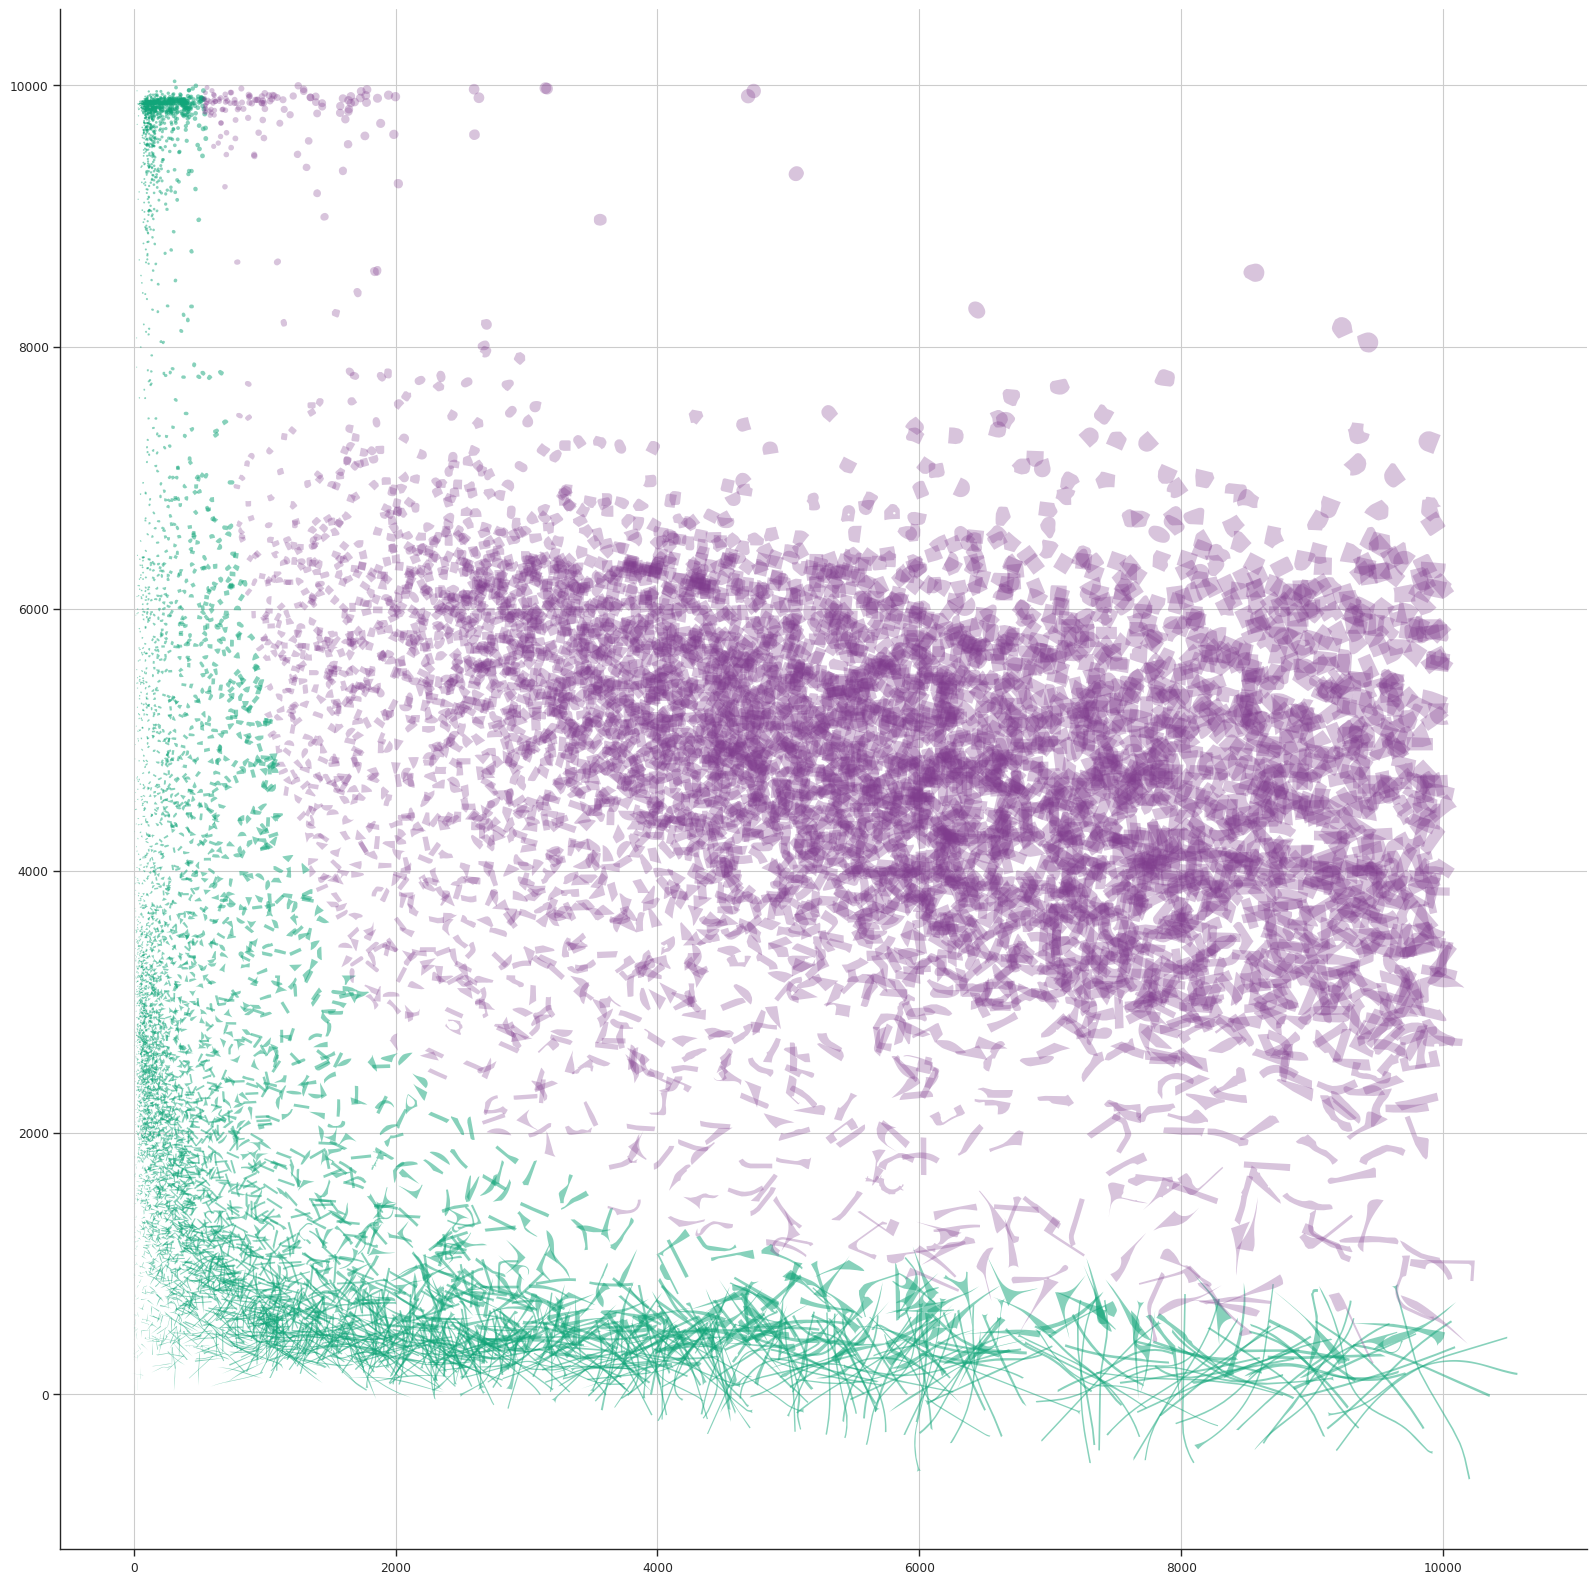

In [39]:
ax = fua_plot.query(f"circular_compactness_index < {threshold}").plot(
    aspect=1, 
    figsize=(20, 20),
    alpha=.5,
    color=Bold_6.hex_colors[1]
)
fua_plot.query(f"circular_compactness_index > {threshold}").plot(
    aspect=1, 
    alpha=.3,
    color=Bold_6.hex_colors[0],
    ax=ax,
)